In [30]:
# 检查TrOCR词汇表是否包含繁体中文
print("="*100)
print("检查TrOCR词汇表对繁体中文的支持")
print("="*100)

# 测试繁体中文字符
traditional_chinese_samples = ['國', '會', '學', '時', '間', '過', '這', '個', '來', '們', '說', '還', '體', '現', '實', '區', '際', '關', '點', '題']
simplified_chinese_samples = ['国', '会', '学', '时', '间', '过', '这', '个', '来', '们', '说', '还', '体', '现', '实', '区', '际', '关', '点', '题']

print(f"\n词汇表总大小: {len(vocab)}")

# 检查繁体字支持
traditional_in_vocab = [char for char in traditional_chinese_samples if char in vocab]
traditional_not_in_vocab = [char for char in traditional_chinese_samples if char not in vocab]

# 检查简体字支持
simplified_in_vocab = [char for char in simplified_chinese_samples if char in vocab]
simplified_not_in_vocab = [char for char in simplified_chinese_samples if char not in vocab]

print(f"\n繁体中文测试:")
print(f"  支持的字符 ({len(traditional_in_vocab)}/{len(traditional_chinese_samples)}): {traditional_in_vocab}")
print(f"  不支持的字符 ({len(traditional_not_in_vocab)}/{len(traditional_chinese_samples)}): {traditional_not_in_vocab}")

print(f"\n简体中文测试:")
print(f"  支持的字符 ({len(simplified_in_vocab)}/{len(simplified_chinese_samples)}): {simplified_in_vocab}")
print(f"  不支持的字符 ({len(simplified_not_in_vocab)}/{len(simplified_chinese_samples)}): {simplified_not_in_vocab}")

# 检查GT中的字符覆盖率
gt_chars = set(gt_for_comparison)
gt_in_vocab = [char for char in gt_chars if char in vocab]
gt_not_in_vocab = [char for char in gt_chars if char not in vocab]

print(f"\nGround Truth字符覆盖率:")
print(f"  总字符数: {len(gt_chars)}")
print(f"  词汇表支持: {len(gt_in_vocab)} ({len(gt_in_vocab)/len(gt_chars)*100:.1f}%)")
print(f"  词汇表不支持: {len(gt_not_in_vocab)} ({len(gt_not_in_vocab)/len(gt_chars)*100:.1f}%)")

if gt_not_in_vocab:
    print(f"\n不支持的字符示例（前30个）: {sorted(gt_not_in_vocab)[:30]}")

print("\n" + "="*100)
print("结论:")
if len(gt_not_in_vocab) / len(gt_chars) > 0.3:
    print("⚠️ 词汇表对繁体中文支持不足！超过30%的字符不在词汇表中。")
    print("   这解释了为什么TrOCR准确率只有40%。")
    print("   该模型主要训练于简体中文，不适合繁体中文识别。")
elif len(gt_not_in_vocab) / len(gt_chars) > 0.1:
    print("⚠️ 词汇表对繁体中文支持有限，约有10-30%的字符不支持。")
else:
    print("✓ 词汇表对繁体中文支持较好，不支持的字符少于10%。")
print("="*100)

检查TrOCR词汇表对繁体中文的支持

词汇表总大小: 2667

繁体中文测试:
  支持的字符 (0/20): []
  不支持的字符 (20/20): ['國', '會', '學', '時', '間', '過', '這', '個', '來', '們', '說', '還', '體', '現', '實', '區', '際', '關', '點', '題']

简体中文测试:
  支持的字符 (20/20): ['国', '会', '学', '时', '间', '过', '这', '个', '来', '们', '说', '还', '体', '现', '实', '区', '际', '关', '点', '题']
  不支持的字符 (0/20): []

Ground Truth字符覆盖率:
  总字符数: 245
  词汇表支持: 149 (60.8%)
  词汇表不支持: 96 (39.2%)

不支持的字符示例（前30个）: ['來', '俗', '倆', '們', '倔', '倫', '值', '儘', '別', '則', '卻', '員', '問', '單', '嗎', '嘆', '場', '奧', '奮', '妄', '實', '寫', '對', '幾', '廬', '惋', '愛', '憂', '懼', '或']

结论:
⚠️ 词汇表对繁体中文支持不足！超过30%的字符不在词汇表中。
   这解释了为什么TrOCR准确率只有40%。
   该模型主要训练于简体中文，不适合繁体中文识别。


---
# Part 1: 环境准备与数据加载
---

## 1. 环境准备

In [1]:
import sys
sys.path.append('..')

import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import re
import torch
from PIL import Image

# TrOCR 相关导入
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

# 配置 matplotlib 中文显示
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'SimSun', 'KaiTi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# 导入自定义模块
from src.custom_ocr import CustomTextRecognizer
from src.custom_ocr.processors import TopKDecoder, CTCDeduplicator, ConfidenceFilter
from src.preprocessing.grid_detection import detect_grid_lines, generate_grid_cells
from src.evaluation import GridAccuracyCalculator

print("✓ 模块导入成功")
print("✓ Matplotlib 中文支持已配置")

c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ 模块导入成功
✓ Matplotlib 中文支持已配置


## 2. 加载测试数据

In [2]:
# 项目根目录
project_root = Path('..').resolve()

# 1. 加载图像
img_path = project_root / 'output' / 'temp_cropped.png'
img = cv2.imread(str(img_path))

if img is None:
    raise FileNotFoundError(f"无法加载图像: {img_path}")

print(f"✓ 加载图像: {img.shape}")

# 2. 加载 Ground Truth（读取为字符串）
gt_file = project_root / 'data' / 'samples' / '2022 第2題 (冬奧) (8份)_Original' / 'sample_01_01_ground_truth.txt'
with open(gt_file, 'r', encoding='utf-8') as f:
    ground_truth = f.read()

print(f"✓ 加载 Ground Truth: {len(ground_truth)} 字符")

# 注意：不在此处清理 ground_truth
# 保留原始格式（包括换行和空格），让 GridAccuracyCalculator 内部的 TextAligner 处理
# 这样可以保留行结构，确保正确的行列对齐

print(f"前 50 字符: {ground_truth[:50]}")

✓ 加载图像: (2900, 2170, 3)
✓ 加载 Ground Truth: 711 字符
前 50 字符: 親愛的你：
  你好！我是一名普通的香港人。首先，請
容許我爲自己的俗氣致歉。畢竟我倆素未謀面
，再


## 3. 格子检测与分割

In [3]:
# 转换为灰度图
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 检测格子线
print("检测格子线...")
lines = detect_grid_lines(gray)
horizontal_lines = lines['horizontal']
vertical_lines = lines['vertical']
print(f"✓ 检测到横线: {len(horizontal_lines)} 条")
print(f"✓ 检测到竖线: {len(vertical_lines)} 条")

# 生成格子
print("\n生成格子网格...")
cells = generate_grid_cells(horizontal_lines, vertical_lines, img.shape[:2])
print(f"✓ 生成格子: {len(cells)} 个")

# 过滤非空格子并裁剪图像
print("\n过滤非空格子并裁剪...")
cell_images = []
non_empty_cells = []

for cell in cells:
    x1, y1, x2, y2 = cell['x1'], cell['y1'], cell['x2'], cell['y2']
    cell_img = img[y1:y2, x1:x2]
    
    # 判断是否为非空格子
    if cell_img.size > 0:
        gray_cell = cv2.cvtColor(cell_img, cv2.COLOR_BGR2GRAY)
        
        # 裁剪中心区域（避免边框干扰）
        h, w = gray_cell.shape
        crop = int(min(h, w) * 0.08)  # 裁剪 8%
        if h > 2*crop and w > 2*crop:
            center_region = gray_cell[crop:h-crop, crop:w-crop]
        else:
            center_region = gray_cell
        
        # 计算中心区域的非白色像素比例
        non_white_ratio = (center_region < 240).sum() / center_region.size
        if non_white_ratio > 0.005:  # 超过0.5%的非白色像素认为是非空
            cell_images.append(cell_img)
            non_empty_cells.append(cell)

print(f"✓ 非空格子数: {len(cell_images)}")
print(f"✓ Ground Truth 原始字符数: {len(ground_truth)}")

检测格子线...
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 532
✓ Ground Truth 原始字符数: 711
✓ 检测到横线: 259 条
✓ 检测到竖线: 190 条

生成格子网格...
✓ 生成格子: 580 个

过滤非空格子并裁剪...
✓ 非空格子数: 532
✓ Ground Truth 原始字符数: 711


---
# Part 2: PaddleOCR 识别（基线）
---

## 4. PaddleOCR 识别

In [4]:
# 初始化 PaddleOCR
print("初始化 PaddleOCR...")
print("="*80)

paddle_recognizer = CustomTextRecognizer(
    model_name='PP-OCRv5_server_rec',
    device='gpu:0'
)

print("✓ PaddleOCR 初始化完成")

# 初始化后处理器
decoder = TopKDecoder(k=5)
deduplicator = CTCDeduplicator()
conf_filter = ConfidenceFilter(threshold=0.3)

print("✓ 后处理器初始化完成")

初始化 PaddleOCR...


Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Quenton\.paddlex\official_models\PP-OCRv5_server_rec`.
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:718: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_cnn64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_precompiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_engines_runtime_compiled64_9.dll" or one of its dependencies.
找不到指定的程序。 Error loading "c:\Users\Quenton\Documents\Github\writtingOCR\venv\lib\site-packages\paddle\..\nvidia\cudnn\bin\cudnn_heuristic64_9.dll" or one of its dependencies.
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0
✓ PaddleOCR 初始化完成
✓ 后处理器初始化完成
✓ 加载模型: PP-OCRv5_server_rec
✓ 字符类别数: 18385
✓ 设备: gpu:0
✓ PaddleOCR 初始化完成
✓ 后处理器初始化完成


In [5]:
# 批量识别
print("\nPaddleOCR 批量识别...")
print("="*80)

# 获取原始概率矩阵
batch_raw_outputs = paddle_recognizer.batch_predict_with_raw_output(cell_images)
print(f"✓ 获取 {len(batch_raw_outputs)} 个格子的概率矩阵")

# 方法链式调用后处理
paddle_results = []
for i, raw_output in enumerate(batch_raw_outputs):
    decoded = decoder(raw_output)
    deduped = deduplicator(decoded)
    filtered = conf_filter(deduped)
    paddle_results.append(filtered)
    
    if i < 10:
        print(f"  格子 {i+1:3d}: '{filtered.get('text', ''):8s}' (置信度: {filtered.get('confidence', 0):.3f})")

print(f"\n✓ PaddleOCR 识别完成: {len(paddle_results)} 个非空格子")


PaddleOCR 批量识别...
✓ 获取 532 个格子的概率矩阵
  格子   1: '親       ' (置信度: 0.975)
  格子   2: '爱       ' (置信度: 0.865)
  格子   3: '的       ' (置信度: 0.999)
  格子   4: '你       ' (置信度: 0.996)
  格子   5: '.co     ' (置信度: 0.539)
  格子   6: '你       ' (置信度: 0.998)
  格子   7: '好       ' (置信度: 0.996)
  格子   8: '1       ' (置信度: 0.503)
  格子   9: '我       ' (置信度: 1.000)
  格子  10: '是       ' (置信度: 0.999)
✓ 获取 532 个格子的概率矩阵
  格子   1: '親       ' (置信度: 0.975)
  格子   2: '爱       ' (置信度: 0.865)
  格子   3: '的       ' (置信度: 0.999)
  格子   4: '你       ' (置信度: 0.996)
  格子   5: '.co     ' (置信度: 0.539)
  格子   6: '你       ' (置信度: 0.998)
  格子   7: '好       ' (置信度: 0.996)
  格子   8: '1       ' (置信度: 0.503)
  格子   9: '我       ' (置信度: 1.000)
  格子  10: '是       ' (置信度: 0.999)

✓ PaddleOCR 识别完成: 532 个非空格子

✓ PaddleOCR 识别完成: 532 个非空格子


In [6]:
# 辅助函数：恢复空格子
def restore_empty_cells(results_list, cells, non_empty_cells):
    """恢复空格子，构建完整的预测结果"""
    all_cells_dict = {}
    
    # 初始化所有格子为空
    for cell in cells:
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': '',
            'confidence': 1.0,
            'is_empty': True
        }
    
    # 填充非空格子的识别结果
    for result, cell in zip(results_list, non_empty_cells):
        row, col = cell['row'], cell['col']
        all_cells_dict[(row, col)] = {
            'row': row,
            'col': col,
            'text': result.get('text', ''),
            'confidence': result.get('confidence', 0),
            'is_empty': False,
            'ocr_result': result
        }
    
    # 转换为列表（按 row, col 排序）
    prediction_data_full = sorted(all_cells_dict.values(), 
                                  key=lambda x: (x['row'], x['col']))
    
    return prediction_data_full

# 恢复空格子
paddle_prediction_full = restore_empty_cells(paddle_results, cells, non_empty_cells)
print(f"✓ 完整预测结果: {len(paddle_prediction_full)} 个格子")
print(f"  - 非空格子: {len([c for c in paddle_prediction_full if not c['is_empty']])} 个")
print(f"  - 空格子: {len([c for c in paddle_prediction_full if c['is_empty']])} 个")

✓ 完整预测结果: 580 个格子
  - 非空格子: 532 个
  - 空格子: 48 个


---
# Part 3: TrOCR 识别
---

## 5. TrOCR 模型加载与识别

In [15]:
print("="*80)
print("TrOCR 模型加载")
print("="*80)

# 加载 TrOCR 中文手写模型（本地路径）
print("\n加载 TrOCR 中文手写模型...")
model_path = project_root / 'TrOCR-Chinese' / 'TAL_OCR_CHN'
processor = TrOCRProcessor.from_pretrained(str(model_path))
model = VisionEncoderDecoderModel.from_pretrained(str(model_path))

# 移动到 GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

# 获取自定义词汇表（用于解码）
vocab = processor.tokenizer.get_vocab()
vocab_inp = {vocab[key]: key for key in vocab}  # 反向词典: {ID: 字符}

print(f"✓ 模型加载完成，使用设备: {device}")
print(f"✓ 模型路径: {model_path}")
print(f"✓ 词汇表大小: {len(vocab)}")
print(f"✓ 词汇表大小: {len(vocab)}")

TrOCR 模型加载

加载 TrOCR 中文手写模型...
✓ 模型加载完成，使用设备: cuda
✓ 模型路径: C:\Users\Quenton\Documents\Github\writtingOCR\TrOCR-Chinese\TAL_OCR_CHN
✓ 词汇表大小: 2667
✓ 词汇表大小: 2667
✓ 模型加载完成，使用设备: cuda
✓ 模型路径: C:\Users\Quenton\Documents\Github\writtingOCR\TrOCR-Chinese\TAL_OCR_CHN
✓ 词汇表大小: 2667
✓ 词汇表大小: 2667


In [16]:
# TrOCR 批量识别
print("\nTrOCR 批量识别...")
print("="*80)

trocr_results = []
with torch.no_grad():
    for i, cell_img in enumerate(cell_images):
        # 转换为 PIL Image (RGB)
        cell_img_rgb = cv2.cvtColor(cell_img, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(cell_img_rgb)
        
        # 预处理（注意：图像需要在列表中）
        pixel_values = processor([pil_image], return_tensors="pt").pixel_values.to(device)
        
        # 生成文本
        generated_ids = model.generate(
            pixel_values,
            max_new_tokens=16,  # 允许生成最多16个字符
            num_beams=1,
            do_sample=False
        )
        
        # 解码（使用自定义decode逻辑，参考GitHub trocr-chinese）
        generated_tokens = generated_ids[0].cpu().numpy()
        generated_text = ''
        
        # Special token IDs
        s_start = vocab.get('<s>')
        s_end = vocab.get('</s>')
        unk = vocab.get('<unk>')
        pad = vocab.get('<pad>')
        
        for tk in generated_tokens:
            if tk == s_end:  # 遇到结束符停止
                break
            if tk not in [s_end, s_start, pad, unk]:
                generated_text += vocab_inp.get(tk, '')
        
        # TrOCR 不直接提供置信度,设为固定值
        trocr_results.append({
            'text': generated_text,
            'confidence': 0.5  # 占位值
        })
        
        if i < 10:
            print(f"  格子 {i+1:3d}: '{generated_text:8s}'")
        
        if (i + 1) % 50 == 0:
            print(f"  处理进度: {i+1}/{len(cell_images)}")

print(f"\n✓ TrOCR 识别完成: {len(trocr_results)} 个非空格子")


TrOCR 批量识别...
  格子   1: '亲是真     '
  格子   2: '爱       '
  格子   3: '美的      '
  格子   4: '【克夫孙】）】）>>>'
  格子   1: '亲是真     '
  格子   2: '爱       '
  格子   3: '美的      '
  格子   4: '【克夫孙】）】）>>>'
  格子   5: '二十年华    '
  格子   6: '森你      '
  格子   7: '姜子      '
  格子   8: '王沂孙     '
  格子   9: '我：我     '
  格子   5: '二十年华    '
  格子   6: '森你      '
  格子   7: '姜子      '
  格子   8: '王沂孙     '
  格子   9: '我：我     '
  格子  10: '六是。     '
  格子  10: '六是。     '
  处理进度: 50/532
  处理进度: 50/532
  处理进度: 100/532
  处理进度: 100/532
  处理进度: 150/532
  处理进度: 150/532
  处理进度: 200/532
  处理进度: 200/532
  处理进度: 250/532
  处理进度: 250/532
  处理进度: 300/532
  处理进度: 300/532
  处理进度: 350/532
  处理进度: 350/532
  处理进度: 400/532
  处理进度: 400/532
  处理进度: 450/532
  处理进度: 450/532
  处理进度: 500/532
  处理进度: 500/532

✓ TrOCR 识别完成: 532 个非空格子

✓ TrOCR 识别完成: 532 个非空格子


In [17]:
# 恢复空格子
trocr_prediction_full = restore_empty_cells(trocr_results, cells, non_empty_cells)
print(f"✓ 完整预测结果: {len(trocr_prediction_full)} 个格子")

✓ 完整预测结果: 580 个格子


---
# Part 4: 准确率评估与对比
---

## 6. 准确率评估

In [18]:
# 创建计算器实例
calculator = GridAccuracyCalculator(empty_char='')

# 评估 PaddleOCR
print("评估 PaddleOCR...")
print("="*80)
paddle_metrics = calculator.calculate(
    predicted_results=paddle_prediction_full,
    ground_truth=ground_truth,
    align_by_row=True
)

print(f"\nPaddleOCR 准确率:")
print(f"  字符准确率: {paddle_metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {paddle_metrics['overall']['matched_chars']}/{paddle_metrics['overall']['total_chars']}")

# 评估 TrOCR
print("\n评估 TrOCR...")
print("="*80)
trocr_metrics = calculator.calculate(
    predicted_results=trocr_prediction_full,
    ground_truth=ground_truth,
    align_by_row=True
)

print(f"\nTrOCR 准确率:")
print(f"  字符准确率: {trocr_metrics['overall']['accuracy']:.2f}%")
print(f"  正确字符数: {trocr_metrics['overall']['matched_chars']}/{trocr_metrics['overall']['total_chars']}")

评估 PaddleOCR...

PaddleOCR 准确率:
  字符准确率: 75.00%
  正确字符数: 387/516

评估 TrOCR...

TrOCR 准确率:
  字符准确率: 40.12%
  正确字符数: 207/516


## 7. 结果对比

In [19]:
# 对比结果
print("\n" + "="*80)
print("准确率对比")
print("="*80)

paddle_acc = paddle_metrics['overall']['accuracy']
trocr_acc = trocr_metrics['overall']['accuracy']
improvement = trocr_acc - paddle_acc

paddle_correct = paddle_metrics['overall']['matched_chars']
trocr_correct = trocr_metrics['overall']['matched_chars']
char_improvement = trocr_correct - paddle_correct

print(f"\n{'指标':<20} {'PaddleOCR':>15} {'TrOCR':>15} {'提升':>15}")
print("-"*80)
print(f"{'字符准确率':<20} {paddle_acc:>14.2f}% {trocr_acc:>14.2f}% {improvement:>+14.2f}%")
print(f"{'正确字符数':<20} {paddle_correct:>15} {trocr_correct:>15} {char_improvement:>+15}")
print(f"{'总字符数':<20} {paddle_metrics['overall']['total_chars']:>15} {trocr_metrics['overall']['total_chars']:>15} {0:>15}")


准确率对比

指标                         PaddleOCR           TrOCR              提升
--------------------------------------------------------------------------------
字符准确率                         75.00%          40.12%         -34.88%
正确字符数                            387             207            -180
总字符数                             516             516               0


## 8. 识别结果对比示例

In [20]:
# 重构格子数据以便对比
def reconstruct_cell_data(metrics_dict):
    """从 by_row 结构重构完整的格子列表"""
    cells = []
    for row_result in metrics_dict['by_row']:
        row_idx = row_result['row']
        for col_idx, (pred_text, gt_text, conf) in enumerate(
            zip(row_result['pred_cells'], row_result['gt_cells'], 
                row_result['confidences'])
        ):
            cells.append({
                'row': row_idx,
                'col': col_idx,
                'text': pred_text,
                'confidence': conf,
                'is_empty': (pred_text == '')
            })
    return cells

# 重构格子数据
paddle_cells = reconstruct_cell_data(paddle_metrics)
trocr_cells = reconstruct_cell_data(trocr_metrics)

# 显示对比示例
print("="*100)
print("识别结果对比示例（前 30 个非空格子）")
print("="*100)

print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15} {'PaddleOCR✓':<12} {'TrOCR✓':<12}")
print("-"*100)

# 只显示非空格子
paddle_non_empty = [c for c in paddle_cells if not c['is_empty']]
trocr_non_empty = [c for c in trocr_cells if not c['is_empty']]

# 从 ground_truth 构建用于对比的字符列表（去除标记和格式）
gt_for_comparison = re.sub(r'<insert>.*?</insert>', '', ground_truth, flags=re.DOTALL)
gt_for_comparison = re.sub(r'<\?>', '', gt_for_comparison)
gt_for_comparison = gt_for_comparison.replace('\n', '').replace(' ', '')

for i in range(min(30, len(paddle_non_empty), len(trocr_non_empty))):
    # 从清理后的 GT 获取对应位置的字符
    gt_char = gt_for_comparison[i] if i < len(gt_for_comparison) else ''
    paddle_text = paddle_non_empty[i]['text']
    trocr_text = trocr_non_empty[i]['text']
    
    paddle_correct = '✓' if paddle_text == gt_char else '✗'
    trocr_correct = '✓' if trocr_text == gt_char else '✗'
    
    print(f"{i+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15} {paddle_correct:<12} {trocr_correct:<12}")
    print(f"{i+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15} {paddle_correct:<12} {trocr_correct:<12}")

识别结果对比示例（前 30 个非空格子）

序号     Ground Truth    PaddleOCR       TrOCR           PaddleOCR✓   TrOCR✓      
----------------------------------------------------------------------------------------------------
1      親               親               亲是真             ✓            ✗           
1      親               親               亲是真             ✓            ✗           
2      愛               爱               爱               ✗            ✗           
2      愛               爱               爱               ✗            ✗           
3      的               的               美的              ✓            ✗           
3      的               的               美的              ✓            ✗           
4      你               你               【克夫孙】）】）>>>     ✓            ✗           
4      你               你               【克夫孙】）】）>>>     ✓            ✗           
5      ：               .co             二十年华            ✗            ✗           
5      ：               .co             二十年华            ✗           

## 9. 错误案例分析

In [21]:
# 错误案例分析
print("="*100)
print("错误案例分析")
print("="*100)

paddle_non_empty = [c for c in paddle_cells if not c['is_empty']]
trocr_non_empty = [c for c in trocr_cells if not c['is_empty']]

both_correct = []
both_wrong = []
paddle_only = []  # 只有 PaddleOCR 正确
trocr_only = []   # 只有 TrOCR 正确

for i in range(min(len(paddle_non_empty), len(trocr_non_empty), len(gt_for_comparison))):
    gt_char = gt_for_comparison[i]
    paddle_text = paddle_non_empty[i]['text']
    trocr_text = trocr_non_empty[i]['text']
    
    paddle_correct = (paddle_text == gt_char)
    trocr_correct = (trocr_text == gt_char)
    
    if paddle_correct and trocr_correct:
        both_correct.append(i)
    elif not paddle_correct and not trocr_correct:
        both_wrong.append((i, gt_char, paddle_text, trocr_text))
    elif paddle_correct and not trocr_correct:
        paddle_only.append((i, gt_char, paddle_text, trocr_text))
    else:  # trocr_correct and not paddle_correct
        trocr_only.append((i, gt_char, paddle_text, trocr_text))

print(f"\n✓ 两者都正确: {len(both_correct)} 个")
print(f"✗ 两者都错误: {len(both_wrong)} 个")
print(f"⚡ 仅 PaddleOCR 正确: {len(paddle_only)} 个")
print(f"⚡ 仅 TrOCR 正确: {len(trocr_only)} 个")

# 显示 TrOCR 优势案例
if trocr_only:
    print(f"\n\n{'='*100}")
    print("TrOCR 优势案例（TrOCR 正确，PaddleOCR 错误）")
    print("="*100)
    print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
    print("-"*100)
    for idx, gt_char, paddle_text, trocr_text in trocr_only[:10]:
        print(f"{idx+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15}")

# 显示 PaddleOCR 优势案例
if paddle_only:
    print(f"\n\n{'='*100}")
    print("PaddleOCR 优势案例（PaddleOCR 正确，TrOCR 错误）")
    print("="*100)
    print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
    print("-"*100)
    for idx, gt_char, paddle_text, trocr_text in paddle_only[:10]:
        print(f"{idx+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15}")

# 显示两者都错误的案例
if both_wrong:
    print(f"\n\n{'='*100}")
    print("两者都错误的案例")
    print("="*100)
    print(f"\n{'序号':<6} {'Ground Truth':<15} {'PaddleOCR':<15} {'TrOCR':<15}")
    print("-"*100)
    for idx, gt_char, paddle_text, trocr_text in both_wrong[:10]:
        print(f"{idx+1:<6} {gt_char:<15} {paddle_text:<15} {trocr_text:<15}")

错误案例分析

✓ 两者都正确: 0 个
✗ 两者都错误: 474 个
⚡ 仅 PaddleOCR 正确: 9 个
⚡ 仅 TrOCR 正确: 14 个


TrOCR 优势案例（TrOCR 正确，PaddleOCR 错误）

序号     Ground Truth    PaddleOCR       TrOCR          
----------------------------------------------------------------------------------------------------
15     的               香               的              
17     港               人               港              
24     容               許               容              
26     我               為               我              
30     的               俗               的              
33     致               歉               致              
34     歉               一               歉              
37     竟               我               竟              
38     我               俩               我              
51     名               實               名              


PaddleOCR 优势案例（PaddleOCR 正确，TrOCR 错误）

序号     Ground Truth    PaddleOCR       TrOCR          
------------------------------------------------------------------------------------

## 10. 结论与建议

In [22]:
print("="*100)
print("实验结论")
print("="*100)

improvement = trocr_acc - paddle_acc

print(f"\n1. 字符准确率提升: {improvement:+.2f}%")
print(f"2. 字符改进数: {char_improvement:+d} 个")
print(f"3. TrOCR 独有优势: {len(trocr_only)} 个格子")
print(f"4. PaddleOCR 独有优势: {len(paddle_only)} 个格子")
print(f"5. 净优势: {len(trocr_only) - len(paddle_only):+d} 个格子")

print("\n" + "="*100)
if improvement > 3:
    print("✅ 建议：TrOCR 效果显著提升，值得投入时间开发 Top-K 支持")
    print("   - 建议下一步：开发 TrOCR 的 Top-K 候选输出功能")
    print("   - 预期收益：进一步结合 BERT 上下文增强")
elif improvement > 1:
    print("⚠️ 建议：TrOCR 有轻微提升，可以考虑但需权衡开发成本")
    print("   - 建议下一步：分析错误案例，评估提升潜力")
    print("   - 权衡因素：开发时间 vs 1-3% 准确率提升")
else:
    print("❌ 建议：TrOCR 提升不明显，不建议替换 PaddleOCR")
    print("   - 原因：TrOCR 主要训练英文手写，中文效果有限")
    print("   - 建议：继续优化 PaddleOCR + BERT 组合")

print("\n注意事项：")
print("1. TrOCR 主要训练英文手写，中文效果可能需要微调")
print("2. 当前测试未使用 Top-K，实际集成需要额外开发")
print("3. TrOCR 推理速度较 PaddleOCR 慢，需考虑效率")
print("4. 如需继续研究 TrOCR，建议尝试：")
print("   - 使用中文预训练的 TrOCR 模型")
print("   - 在手写中文数据集上微调")
print("   - 提取 logits 实现 Top-K 候选输出")
print("="*100)

实验结论

1. 字符准确率提升: -34.88%
2. 字符改进数: -180 个
3. TrOCR 独有优势: 14 个格子
4. PaddleOCR 独有优势: 9 个格子
5. 净优势: +5 个格子

❌ 建议：TrOCR 提升不明显，不建议替换 PaddleOCR
   - 原因：TrOCR 主要训练英文手写，中文效果有限
   - 建议：继续优化 PaddleOCR + BERT 组合

注意事项：
1. TrOCR 主要训练英文手写，中文效果可能需要微调
2. 当前测试未使用 Top-K，实际集成需要额外开发
3. TrOCR 推理速度较 PaddleOCR 慢，需考虑效率
4. 如需继续研究 TrOCR，建议尝试：
   - 使用中文预训练的 TrOCR 模型
   - 在手写中文数据集上微调
   - 提取 logits 实现 Top-K 候选输出


## 11. 可视化识别结果对比

并排显示PaddleOCR和TrOCR的网格识别结果

可视化网格识别结果...

网格尺寸: 29 行 × 20 列
显示范围: 29 行 × 20 列


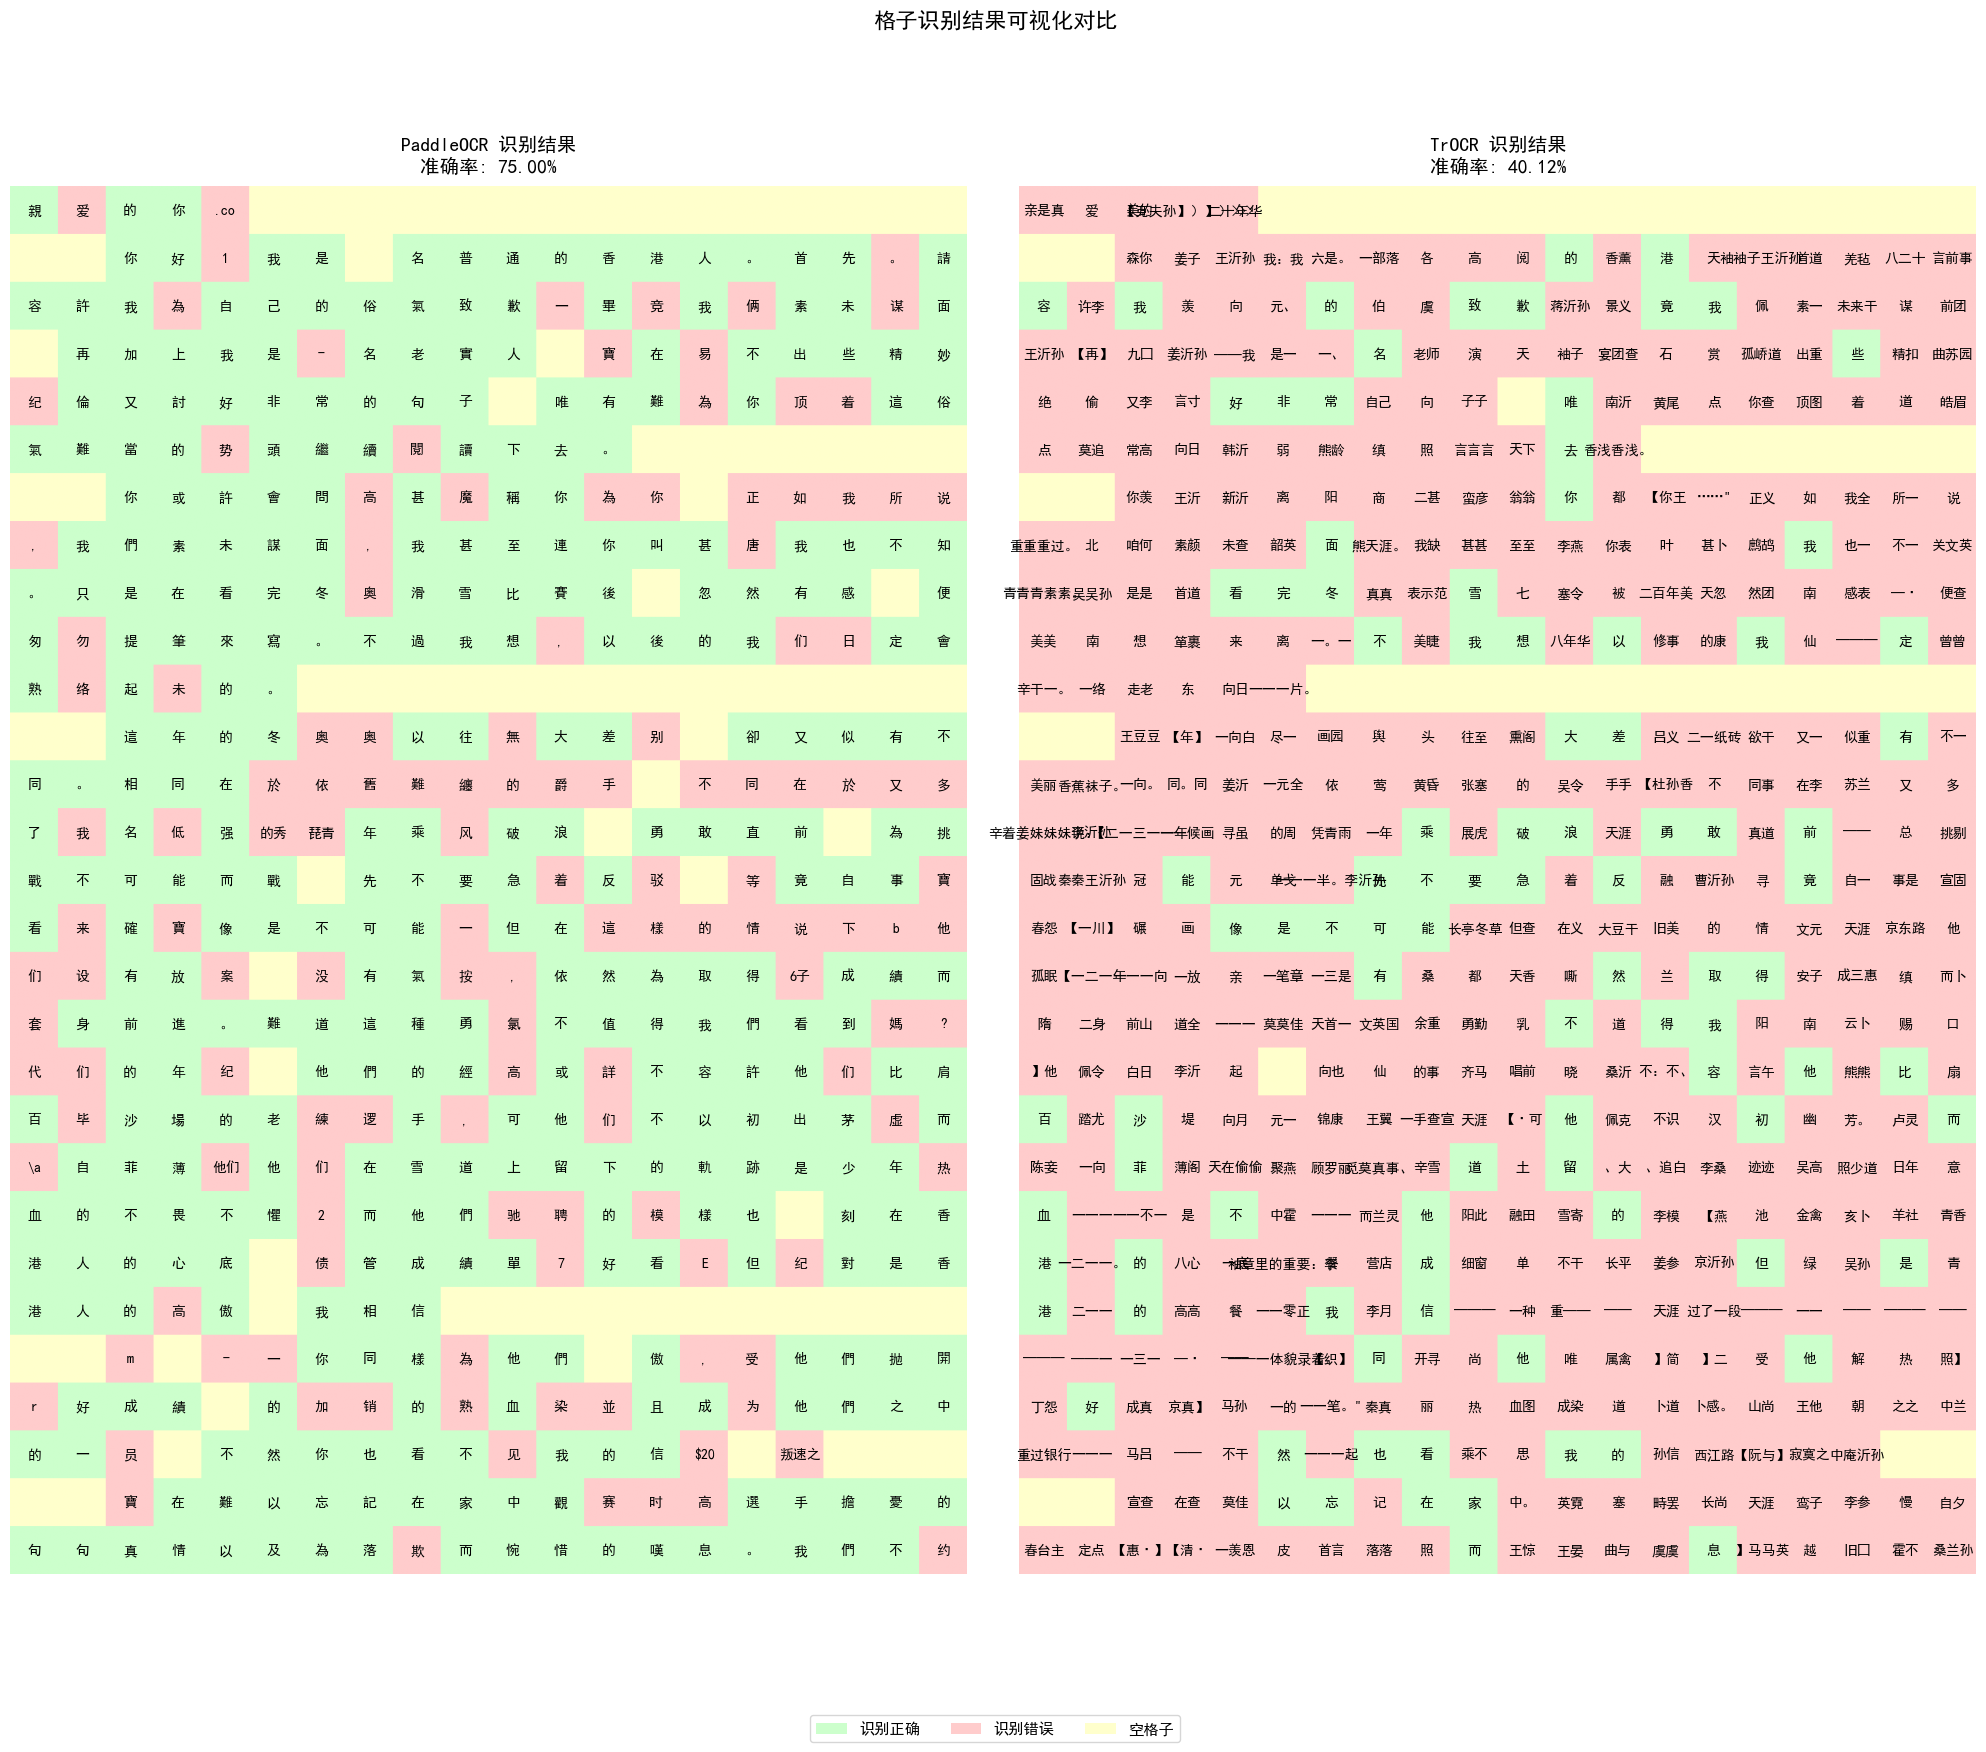


✓ 可视化完成
  - 左侧：PaddleOCR (准确率: 75.00%)
  - 右侧：TrOCR (准确率: 40.12%)
  - 浅绿色：识别正确
  - 粉红色：识别错误
  - 浅黄色：空格子


In [29]:
# 可视化PaddleOCR vs TrOCR识别结果
print("="*100)
print("可视化网格识别结果...")
print("="*100)

# 获取网格尺寸
rows = max([cell['row'] for cell in cells]) + 1
cols = max([cell['col'] for cell in cells]) + 1

# 限制显示范围
max_display_rows = min(rows, 30)
max_display_cols = min(cols, 20)

print(f"\n网格尺寸: {rows} 行 × {cols} 列")
print(f"显示范围: {max_display_rows} 行 × {max_display_cols} 列")

# 创建格子索引字典（包含GT信息）
paddle_cell_dict = {}
trocr_cell_dict = {}

# 从metrics的by_row结构中提取GT信息
paddle_gt_dict = {}
trocr_gt_dict = {}

for row_result in paddle_metrics['by_row']:
    row = row_result['row']
    for col, gt_char in enumerate(row_result['gt_cells']):
        paddle_gt_dict[(row, col)] = gt_char

for row_result in trocr_metrics['by_row']:
    row = row_result['row']
    for col, gt_char in enumerate(row_result['gt_cells']):
        trocr_gt_dict[(row, col)] = gt_char

# 构建格子字典
for cell in paddle_cells:
    paddle_cell_dict[(cell['row'], cell['col'])] = cell

for cell in trocr_cells:
    trocr_cell_dict[(cell['row'], cell['col'])] = cell

# 创建双画布
fig, (ax_paddle, ax_trocr) = plt.subplots(1, 2, figsize=(20, max_display_rows * 0.6))

# 处理两个模型的结果
for model_idx, (ax, cell_dict, gt_dict, model_name, accuracy) in enumerate([
    (ax_paddle, paddle_cell_dict, paddle_gt_dict, "PaddleOCR", paddle_acc),
    (ax_trocr, trocr_cell_dict, trocr_gt_dict, "TrOCR", trocr_acc)
]):
    # 创建网格图像
    grid_height = max_display_rows * 50
    grid_width = max_display_cols * 50
    grid_img = np.ones((grid_height, grid_width, 3))
    
    # 遍历网格
    for row in range(max_display_rows):
        for col in range(max_display_cols):
            y_start = row * 50
            y_end = (row + 1) * 50
            x_start = col * 50
            x_end = (col + 1) * 50
            
            # 获取格子
            if (row, col) not in cell_dict:
                # 超出范围或不存在
                grid_img[y_start:y_end, x_start:x_end] = [0.95, 0.95, 0.95]
                continue
            
            cell = cell_dict[(row, col)]
            
            # 从gt_dict获取对应的GT字符（已对齐）
            gt_char = gt_dict.get((row, col), '')
            
            # 判断状态并设置颜色
            if cell.get('is_empty', False):
                # 空格子
                color = [1.0, 1.0, 0.8]  # 浅黄色
                text = ''
            else:
                text = cell['text']
                if text == gt_char:
                    # 识别正确
                    color = [0.8, 1.0, 0.8]  # 浅绿色
                else:
                    # 识别错误
                    color = [1.0, 0.8, 0.8]  # 粉红色
            
            # 填充颜色
            grid_img[y_start:y_end, x_start:x_end] = color
            
            # 添加文本（在图像上）
            if text:
                # 计算文本位置（格子中心）
                text_x = x_start + 25
                text_y = y_start + 35
                
                # 使用cv2添加中文文本需要PIL，这里用matplotlib的text
                # 我们在后面统一添加
    
    # 显示网格图像
    ax.imshow(grid_img)
    ax.axis('off')
    ax.set_title(f'{model_name} 识别结果\n准确率: {accuracy:.2f}%', 
                 fontsize=14, fontweight='bold', pad=10)
    
    # 添加文本标签
    for row in range(max_display_rows):
        for col in range(max_display_cols):
            if (row, col) not in cell_dict:
                continue
            
            cell = cell_dict[(row, col)]
            if not cell.get('is_empty', False):
                text = cell['text']
                # 计算文本位置
                x = col * 50 + 25
                y = row * 50 + 25
                
                ax.text(x, y, text, 
                       ha='center', va='center', 
                       fontsize=10, fontweight='bold',
                       color='black')

# 添加总标题和图例
fig.suptitle('格子识别结果可视化对比', fontsize=16, fontweight='bold', y=0.98)

# 添加图例
legend_elements = [
    plt.Rectangle((0, 0), 1, 1, fc=[0.8, 1.0, 0.8], label='识别正确'),
    plt.Rectangle((0, 0), 1, 1, fc=[1.0, 0.8, 0.8], label='识别错误'),
    plt.Rectangle((0, 0), 1, 1, fc=[1.0, 1.0, 0.8], label='空格子')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, 
          frameon=True, fontsize=11, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout(rect=[0, 0.02, 1, 0.96])
plt.show()

print("\n✓ 可视化完成")
print(f"  - 左侧：PaddleOCR (准确率: {paddle_acc:.2f}%)")
print(f"  - 右侧：TrOCR (准确率: {trocr_acc:.2f}%)")
print("  - 浅绿色：识别正确")
print("  - 粉红色：识别错误")
print("  - 浅黄色：空格子")